In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class LearnPosterior(BaseModel):
    LINK = "learn_posterior"

    def __init__(self, config: Config):
        super(LearnPosterior, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        n_baseline = 1
        # n_delta = n_feature0 - 1

        """ Fixed Effects (Baseline) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_baseline", n_baseline):
                a_fixed_mean = numpyro.sample("a_fixed_mean", dist.TruncatedNormal(50, 10, low=0))
                a_fixed_scale = numpyro.sample("a_fixed_scale", dist.HalfNormal(20.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_fixed = numpyro.sample(
                        "a_fixed", dist.TruncatedNormal(a_fixed_mean, a_fixed_scale, low=0)
                    )

        # """ Random Effects (Delta) """
        # with numpyro.plate(site.n_response, self.n_response):
        #     with numpyro.plate("n_delta", n_delta):
        #         a_random_mean = numpyro.sample("a_random_mean", dist.Normal(0, 50))
        #         a_random_scale = numpyro.sample("a_random_scale", dist.HalfNormal(50.0))

        #         with numpyro.plate(site.n_subject, n_subject):
        #             a_random = numpyro.sample("a_random", dist.Normal(a_random_mean, a_random_scale))

        #             """ Penalty """
        #             penalty_for_negative_a = (jnp.fabs(a_fixed + a_random) - (a_fixed + a_random))
        #             numpyro.factor("penalty_for_negative_a", -penalty_for_negative_a)

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(5))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(5))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(5))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(10))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(10))

            with numpyro.plate("n_feature0", n_feature0):
                """ Hyper-priors """
                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("ell_scale", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    # a = numpyro.deterministic(
                    #     site.a,
                    #     jnp.concatenate([a_fixed, a_fixed + a_random], axis=1)
                    # )
                    a = numpyro.deterministic(
                        site.a,
                        a_fixed
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic("ell", jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(10))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )


In [3]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class HBSimulator(BaseModel):
    LINK = "hb_simulator"

    def __init__(self, config: Config, a_random_mean, a_random_scale):
        super(HBSimulator, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.a_random_mean = a_random_mean
        self.a_random_scale = a_random_scale

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Fixed Effects (Baseline) """
        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(5))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(5))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(5))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(5))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(10))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(10))

            with numpyro.plate("n_baseline", n_baseline):
                a_fixed_mean = numpyro.sample("a_fixed_mean", dist.TruncatedNormal(50, 10, low=0))
                a_fixed_scale = numpyro.sample("a_fixed_scale", dist.HalfNormal(20.0))

                """ Hyper-priors """
                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("ell_scale", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    a_fixed = numpyro.sample(
                        "a_fixed", dist.TruncatedNormal(a_fixed_mean, a_fixed_scale, low=0)
                    )

                    b_raw_fixed = numpyro.sample("b_raw_fixed", dist.HalfNormal(scale=1))
                    b_fixed = numpyro.deterministic("b_fixed", jnp.multiply(b_scale, b_raw_fixed))

                    v_raw_fixed = numpyro.sample("v_raw_fixed", dist.HalfNormal(scale=1))
                    v_fixed = numpyro.deterministic("v_fixed", jnp.multiply(v_scale, v_raw_fixed))

                    L_raw_fixed = numpyro.sample("L_raw_fixed", dist.HalfNormal(scale=1))
                    L_fixed = numpyro.deterministic("L_fixed", jnp.multiply(L_scale, L_raw_fixed))

                    ell_raw_fixed = numpyro.sample("ell_raw_fixed", dist.HalfNormal(scale=1))
                    ell_fixed = numpyro.deterministic("ell_fixed", jnp.multiply(ell_scale, ell_raw_fixed))

                    H_raw_fixed = numpyro.sample("H_raw_fixed", dist.HalfNormal(scale=1))
                    H_fixed = numpyro.deterministic("H_fixed", jnp.multiply(H_scale, H_raw_fixed))

                    g_1_raw_fixed = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1_fixed = numpyro.deterministic("g_1_fixed", jnp.multiply(g_1_scale, g_1_raw_fixed))

                    g_2_raw_fixed = numpyro.sample("g_2_raw_fixed", dist.HalfCauchy(scale=1))
                    g_2_fixed = numpyro.deterministic("g_2_fixed", jnp.multiply(g_2_scale, g_2_raw_fixed))

        """ Random Effects (Delta) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_delta", n_delta):
                # a_random_mean = numpyro.sample("a_random_mean", dist.Normal(0, 50))
                # a_random_scale = numpyro.sample("a_random_scale", dist.HalfNormal(50.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_random = numpyro.sample("a_random", dist.TruncatedNormal(self.a_random_mean, self.a_random_scale, high=0))

                    """ Penalty """
                    penalty_for_negative_a = (jnp.fabs(a_fixed + a_random) - (a_fixed + a_random))
                    numpyro.factor("penalty_for_negative_a", -penalty_for_negative_a)

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_feature0", n_feature0):
                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_fixed, a_fixed + a_random], axis=1)
                    )
                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_fixed, b_fixed], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_fixed, v_fixed], axis=1)
                    )
                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_fixed, L_fixed], axis=1)
                    )
                    ell = numpyro.deterministic(
                        "ell",
                        jnp.concatenate([ell_fixed, ell_fixed], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_fixed, H_fixed], axis=1)
                    )
                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_fixed, g_1_fixed], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_fixed, g_2_fixed], axis=1)
                    )

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(10))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )


In [4]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/tms/config.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = os.path.join(config.BUILD_DIR, "experiments", "sparse-subjects", "simulate-data")
config.RESPONSE = ["PKPK_APB"]
config.FEATURES = ["intervention"]
config.MCMC_PARAMS["num_warmup"] = 1000
config.MCMC_PARAMS["num_samples"] = 1000

model = LearnPosterior(config=config)

a_random_mean, a_random_scale = -1.5, 1
simulator = HBSimulator(config=config, a_random_mean=a_random_mean, a_random_scale=a_random_scale)


2023-11-22 16:09:52,367 - hbmep.config - INFO - Verifying configuration ...
2023-11-22 16:09:52,367 - hbmep.config - INFO - Success!
2023-11-22 16:09:52,384 - hbmep.model.baseline - INFO - Initialized base_model
2023-11-22 16:09:52,385 - hbmep.model.baseline - INFO - Initialized base_model


In [5]:
N_SUBJECTS = 10

simulation_df = \
    pd.DataFrame(np.arange(0, N_SUBJECTS, 1), columns=[simulator.subject]) \
    .merge(
        pd.DataFrame(np.arange(0, 2, 1), columns=simulator.features),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 100], columns=[simulator.intensity]),
        how="cross"
    )

simulation_df = simulator.make_prediction_dataset(df=simulation_df, num=60)
simulation_df.shape


2023-11-22 16:09:52,421 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


(1200, 3)

In [6]:
src = "/home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/inference.pkl"
with open(src, "rb") as g:
    _, mcmc_learnt, posterior_samples_learnt = pickle.load(g)

priors = {
    "global-priors": [
        "b_scale_global_scale",
        "v_scale_global_scale",
        "L_scale_global_scale",
        "ell_scale_global_scale",
        "H_scale_global_scale",
        "g_1_scale_global_scale",
        "g_2_scale_global_scale"
    ],

    "hyper-priors": [
        "b_scale_raw",
        "v_scale_raw",
        "L_scale_raw",
        "ell_scale_raw",
        "H_scale_raw",
        "g_1_scale_raw",
        "g_2_scale_raw",

        "b_scale",
        "v_scale",
        "L_scale",
        "sigma_ell",
        "H_scale",
        "g_1_scale",
        "g_2_scale"
    ],

    "baseline-priors": [
        "a_fixed_mean",
        "a_fixed_scale"
    ]
}

sites_to_use_for_simulation = ["outlier_prob"]
sites_to_use_for_simulation += priors["global-priors"]
sites_to_use_for_simulation += priors["hyper-priors"]

posterior_samples_learnt = {
    k: v for k, v in posterior_samples_learnt.items() if k in sites_to_use_for_simulation
}
posterior_samples_learnt["outlier_prob"] = 0 * posterior_samples_learnt["outlier_prob"]


In [7]:
simulation_posterior_predictive = \
    simulator.predict(df=simulation_df, posterior_samples=posterior_samples_learnt)


2023-11-22 16:09:56,806 - hbmep.utils.utils - INFO - func:predict took: 4.16 sec


In [8]:
simulation_obs = simulation_posterior_predictive[site.obs]
simulation_obs.shape


(4000, 1200, 1)

In [9]:
df = simulation_df.copy()
df.shape

(1200, 3)

In [ ]:
N_DRAWS = 5
N_REPEATS = 2

keys = jax.random.split(simulator.rng_key, num=2)
draws_space = \
    jax.random.choice(
        key=keys[0],
        a=np.arange(0, simulation_obs.shape[0], 1),
        shape=(N_DRAWS,),
        replace=False
    ) \
    .tolist()

repeats_space = \
    jax.random.choice(
        key=keys[1],
        a=np.arange(0, n_repeats * 100, 1),
        shape=(n_repeats,),
        replace=False
    ) \
    .tolist()

In [ ]:
jax

In [ ]:
[model.response[0] + f"_{i}" for i in range()]

In [ ]:
dest = os.path.join(SIMULATOR.build_dir, "POSTERIOR_PREDICTIVE.pkl")
with open(dest, "wb") as f:
    pickle.dump((POSTERIOR_PREDICTIVE,), f)
dest

'/home/vishu/out/hbmep-paper/paper/tms/mixed-effects/simulator/hierarchical_bayesian_simulator/mu_a_delta_-1.5__sigma_a_delta_1/POSTERIOR_PREDICTIVE.pkl'

In [ ]:
simulation

In [6]:
posterior_samples_learnt[site.a].shape

(4000, 18, 1, 1)

In [6]:
posterior_samples_learnt.keys()


dict_keys(['H', 'H_raw', 'H_scale', 'H_scale_global_scale', 'H_scale_raw', 'L', 'L_raw', 'L_scale', 'L_scale_global_scale', 'L_scale_raw', 'a', 'a_fixed', 'a_fixed_mean', 'a_fixed_scale', 'a_random', 'a_random_mean', 'a_random_scale', 'b', 'b_raw', 'b_scale', 'b_scale_global_scale', 'b_scale_raw', 'bg_scale', 'ell', 'ell_raw', 'ell_scale_global_scale', 'ell_scale_raw', 'g_1', 'g_1_raw', 'g_1_scale', 'g_1_scale_global_scale', 'g_1_scale_raw', 'g_2', 'g_2_raw', 'g_2_scale', 'g_2_scale_global_scale', 'g_2_scale_raw', 'outlier_prob', 'outlier_scale', 'q', 'sigma_ell', 'v', 'v_raw', 'v_scale', 'v_scale_global_scale', 'v_scale_raw', 'µ', 'β'])

In [ ]:
params_to_use_for_simulation = {
    
}

In [ ]:
# freeze priors
posterior_samples_learnt = {
    
}

Text(0.5, 1.0, '0.79225')

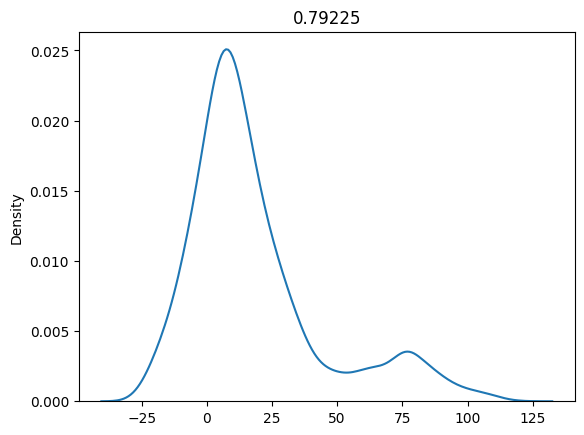

In [9]:
a_random_mean = posterior_samples["a_random_mean"]
a_random_mean.shape

import seaborn as sns
import matplotlib.pyplot as plt

samples = a_random_mean.reshape(-1,)
sns.kdeplot(samples)
plt.title((samples > 0).mean())


In [10]:
_posterior_samples = posterior_samples.copy()
_posterior_samples["outlier_prob"] = _posterior_samples["outlier_prob"] * 0

prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=_posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-22 13:35:22,814 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-11-22 13:35:26,563 - hbmep.utils.utils - INFO - func:predict took: 3.75 sec
2023-11-22 13:35:26,563 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-11-22 13:35:29,698 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/recruitment_curves.pdf
2023-11-22 13:35:29,698 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 3.14 sec
2023-11-22 13:35:29,698 - hbmep.model.baseline - INFO - Rendering posterior predictive checks ...
2023-11-22 13:35:33,196 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/posterior_predictive_check.pdf
2023-11-22 13:35:33,196 - hbmep.utils.utils - INFO - func:predictive_checks_renderer took: 3.50 sec
2023-11-22 13:35:33,196 - hbmep.utils.utils - INFO - func:render_predictive_check took: 3.50 sec


In [12]:
dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)

print(dest)

/home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/inference.pkl


In [13]:
dest = os.path.join(model.build_dir, "inference.nc")
az.to_netcdf(mcmc, dest)
dest

'/home/vishu/repos/hbmep-paper/reports/paper/tms/experiments/sparse-subjects/learn-posterior/inference.nc'

In [16]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")

score = az.loo(numpyro_data, var_name=site.obs)
logger.info(f"ELPD LOO (Log): {score.elpd_loo:.2f}")

score = az.waic(numpyro_data, var_name=site.obs)
logger.info(f"ELPD WAIC (Log): {score.elpd_waic:.2f}")

2023-11-22 13:38:13,518 - __main__ - INFO - Evaluating model ...
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
2023-11-22 13:38:19,343 - __main__ - INFO - ELPD LOO (Log): 1480.75
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities